<a href="https://colab.research.google.com/github/parksamjong/vit/blob/main/Head_based_Image_Classification_with_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Hands-On] Head-based Image Classification with ViT

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

# Image Classification with Vision Transformer (ViT)

In this tutorial, we'll demonstrate how to fine-tune a pre-trained Vision Transformer (ViT) for image classification using the Hugging Face `transformers` library. We'll be working with a fruit dataset that includes images of apples, cherries, and other fruits.

## What is ViT?
The Vision Transformer (ViT) applies the principles of transformers, which have been widely successful in NLP, to image classification tasks. Instead of processing images in the form of pixels or convolutional features, ViT treats an image as a sequence of patches and applies a transformer model to these sequences for classification tasks.

## Dataset
We'll use a subset of a fruit dataset that includes various fruit images categorized into classes like Apple, Cherry, etc.

## Objectives
- Fine-tune a pre-trained ViT model on the fruit dataset.
- Evaluate the model with precision, recall, F1-score, and accuracy metrics.
- Save and reload the model for inference.
- Select random test images, make predictions, and visualize them with their labels.
- Generate a confusion matrix to analyze the model's performance.

Let's get started!


In [1]:
!pip install tensorboard
!pip install -qqq accelerate==0.28.0
!pip install -qqq transformers==4.39.2
!pip install -qqq datasets # huggingface's lib.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00


## Setup and Data Preparation


#### Preparing the Dataset for Image Classification

In this step, we're setting up the dataset required for our image classification project. We start by ensuring a clean workspace, removing any existing dataset directories and files that might be left from previous runs. Then, we download a fresh copy of the dataset from a specified online source. The dataset is provided as a compressed ZIP file to minimize download time and save space.

In [2]:
# !rm data.zip
# !rm -r data
!wget -qq 'https://www.dropbox.com/scl/fi/mf806inzv0x6abbb2su0k/fruit-dataset.zip?rlkey=gk7s9d14m6k9o1ru4whrgtwke&dl=1' -O data.zip
!unzip -qq data.zip -d data/
!echo "Number of Images : $(find ./data -type f | wc -l)"

Number of Images : 2000


In [3]:
# Import necessary libraries
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = load_dataset("./data")
print(dataset)

Resolving data files:   0%|          | 0/1600 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/400 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 400
    })
})


Setting a random seed ensures that the results of your model are reproducible. This is crucial for experimental consistency and for others to verify your results. In deep learning, sources of randomness include weight initialization, data shuffling, and certain stochastic operations. By setting the seed, we ensure that these operations produce the same results each time the code is run.


In [4]:
import os
import random

# Function to set the seed for reproducibility
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # The below two lines are for deterministic algorithm behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed()

### Image Processing

Before feeding images into the ViT model, they need to be preprocessed. This typically involves resizing the image to a fixed size, normalizing pixel values, and converting the image to RGB if it's not already. The ViTFeatureExtractor handles these steps, ensuring that the model receives input in the format it expects.


In [5]:
# Initialize the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Preprocess the dataset
def preprocess_images(examples):
    images = [feature_extractor(image.convert("RGB")) for image in examples["image"]]
    #examples 안에는 batch 단위로 데이터가 들어감, feature_extractor 실행 후 pixel_values라는 값을 포함하는 딕셔너리로 반환
    examples['pixel_values'] = [image['pixel_values'][0] for image in images]
    return examples

dataset = dataset.map(preprocess_images, batched=True) #batch 단위로 처리
dataset.set_format(type='torch', columns=['image', 'pixel_values', 'label'])

# Split the dataset into training and validation sets using Hugging Face's built-in method
train_test_split = dataset["train"].train_test_split(test_size=0.2) # 나눠주는 것

# Assign the split datasets
train_dataset = train_test_split["train"] #각각의 변수에 데이터셋 할당해주는 것
val_dataset = train_test_split["test"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'pixel_values'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['image', 'label', 'pixel_values'],
        num_rows: 400
    })
})

## Load Pre-trained Model

In [7]:
# Ensure you're accessing the 'train' split (or another specific split) to get the features
num_labels = len(dataset['train'].features['label'].names)
print(dataset['train'].features['label'].names)
print(num_labels) # label의 수

# Load pre-trained ViT model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                   num_labels=num_labels) # <--!!!



['apple', 'asian pear', 'banana', 'cherry']
4


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



<img src="https://www.dropbox.com/scl/fi/i7xqf548up7lalc2n2012/vit_head_based_classification.png?rlkey=2q19ej97bnswb8gk7pipc3rkn&dl=1" width="800">


#### Head-based Classification in Vision Transformers (ViT)

In the context of Vision Transformers, 'head-based classification' refers to the addition of a 'head' to the pre-trained transformer model, which is specifically tailored for a classification task. The ViT model, much like its NLP counterparts, processes input data (in this case, image patches) through multiple transformer layers. The output of these layers is then fed into a classification head.

The classification head is typically a fully connected neural network layer that maps the high-dimensional features extracted by the transformer to the number of classes in the dataset. For image classification tasks, this head takes the transformer's output corresponding to the [CLS] token (a special token used by transformers to aggregate information from the entire sequence) and produces a probability distribution over the classes.


Note that
```python
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=num_labels                   
                                                  )

```

#### Adjusting the Classification Head
The 'num_labels' parameter here is crucial as it adjusts the classification head of the ViT model to the number of classes in our fruit dataset. This ensures that the model's output layer is correctly sized to produce a probability distribution over our dataset's specific classes.

In [8]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./vit_fruit_classification",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,

    # logging_dir='./logs',
)

# Function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [9]:
# %load_ext tensorboard
# %tensorboard --logdir ./logs

In [10]:
# Start fine-tuning
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.037761,0.996875,0.996875,0.996912,0.996875
2,No log,0.026194,0.996875,0.996875,0.996912,0.996875
3,No log,0.024810,0.996875,0.996875,0.996912,0.996875


TrainOutput(global_step=240, training_loss=0.07265352408091227, metrics={'train_runtime': 198.2525, 'train_samples_per_second': 19.369, 'train_steps_per_second': 1.211, 'total_flos': 2.9757457415798784e+17, 'train_loss': 0.07265352408091227, 'epoch': 3.0})

## Save and Reload Model

Saving a model after training is crucial for later use in applications or further fine-tuning. In addition to the model, saving the feature extractor is also important, as it ensures that the input preprocessing steps remain consistent.

In [11]:
# Save the fine-tuned model
model.save_pretrained("./vit_fruit_cls")
# Save the feature extractor
feature_extractor.save_pretrained('./vit_fruit_cls')

['./vit_fruit_cls/preprocessor_config.json']

## Make Predictions and Visualize


In [12]:
from transformers import pipeline

# Load the pipeline with the model and feature extractor
image_classifier = pipeline('image-classification',
                            model='./vit_fruit_cls',
                            feature_extractor='./vit_fruit_cls')

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Iterate Over the Test Dataset for Predictions

In [13]:
dataset['test']['image'].shape

torch.Size([400, 3, 256, 256])

After making predictions on the test set, it's important to evaluate the model using metrics such as accuracy, precision, recall, and F1-score. These metrics provide a comprehensive view of the model's performance, highlighting its strengths and areas for improvement. Accuracy gives a general idea of the model's performance, while precision, recall, and F1-score offer deeper insights into its behavior across different classes.

In [14]:
from PIL import Image
import torchvision.transforms.functional as TF
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

true_labels = []
pred_labels = []
scores = []  # List to store probability values

for item in tqdm(dataset['test']):
    # Convert the PyTorch tensor to a PIL Image
    # The permute operation was incorrect. We need to keep the channel dimension last
    # Original: t_img = item['image'].permute(2, 0, 1)
    # Corrected:
    image = TF.to_pil_image(item['image'])  # Directly convert without permuting

    # Use the pipeline to predict the class of each image
    pred = image_classifier(image)
    pred_label = pred[0]['label']

    # Extract score for the predicted label
    score = pred[0]['score']

    # Convert predicted label to the corresponding index
    pred_label_idx = int(pred_label.split('_')[-1])

    true_labels.append(item['label'])
    pred_labels.append(pred_label_idx)
    scores.append(score)  # Append score to the list

# Convert lists to numpy arrays for metric calculation
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
recall = recall_score(true_labels, pred_labels, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
f1 = f1_score(true_labels, pred_labels, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed

# Print the metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

100%|██████████| 400/400 [03:29<00:00,  1.91it/s]

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


## Confusion Matrix

A confusion matrix is a powerful tool for understanding a model's performance across different classes. It shows the true vs. predicted classifications, helping identify patterns of misclassification. Analyzing the confusion matrix can reveal whether the model is confusing two classes, which can inform further tuning or adjustments.


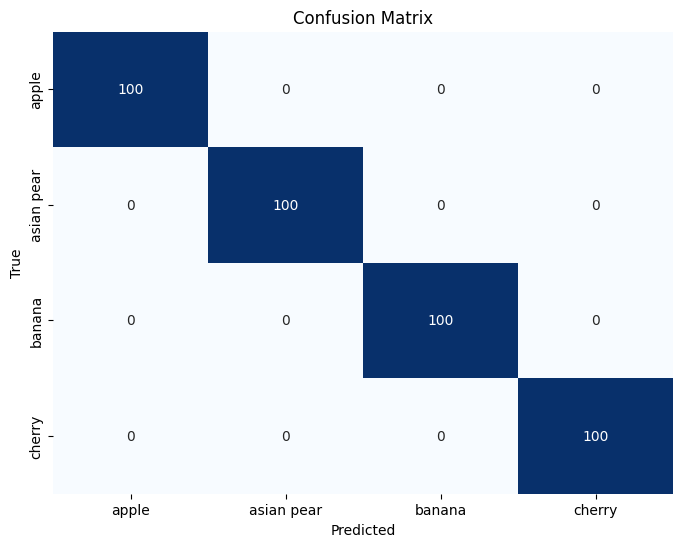

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Access the classes attribute to obtain class labels
classes = dataset['train'].features['label'].names

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(len(classes)), yticklabels=range(len(classes)))

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)
plt.show()

#### Visualizing Predictions
Visualizing the model's predictions alongside the true labels can provide intuitive insights into its performance.

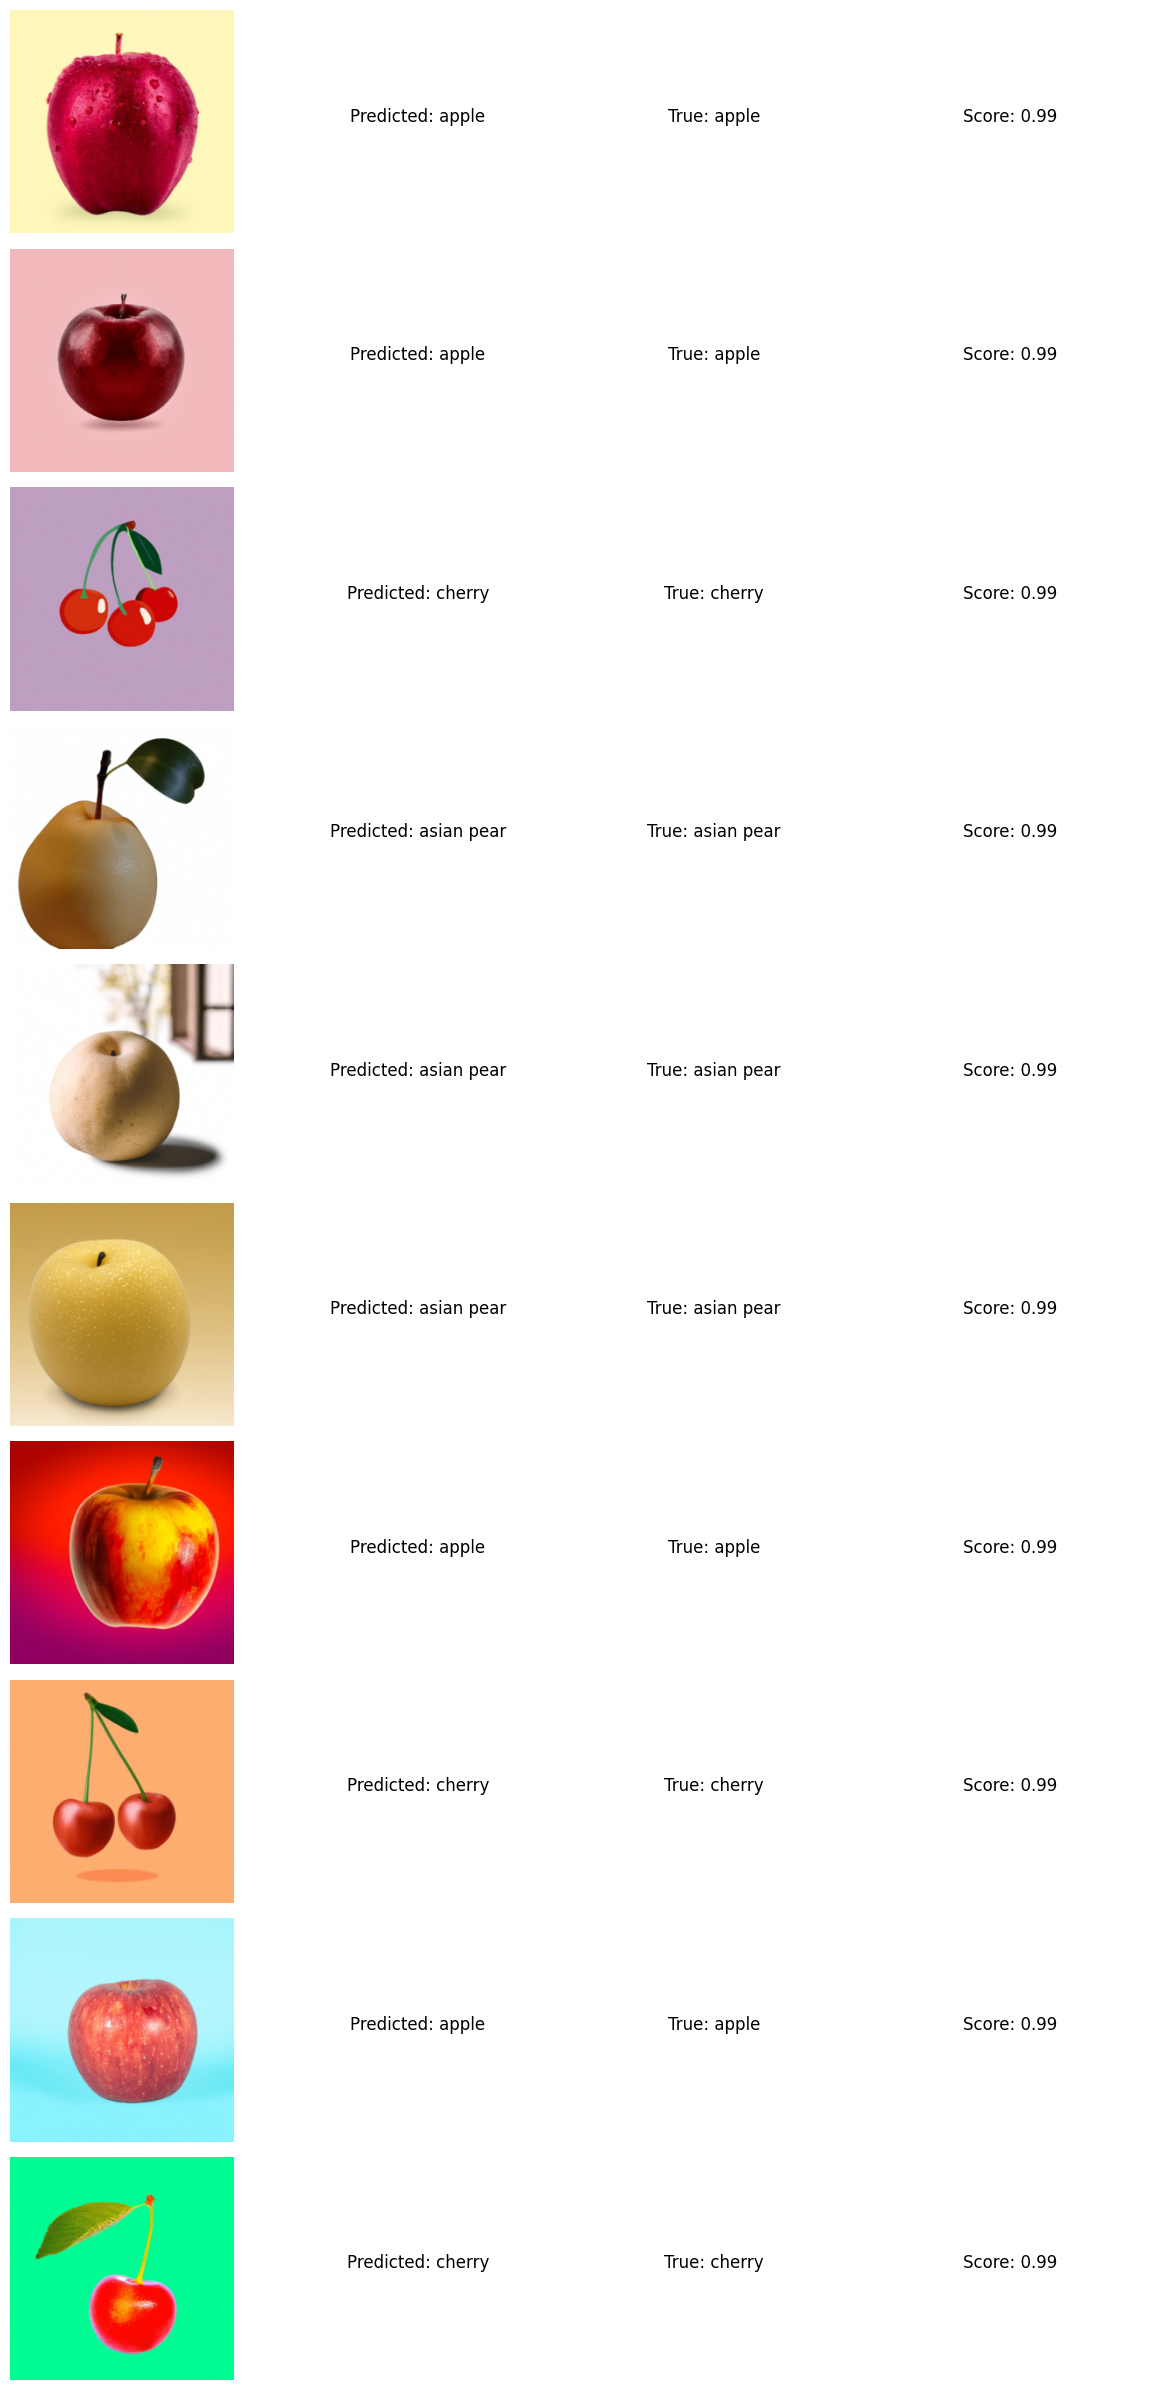

In [17]:
import matplotlib.pyplot as plt
import random

# Define a function to display predictions with class names
def display_predictions(dataset, true_labels, pred_labels, class_names, scores, num_samples=10):
    fig, axs = plt.subplots(num_samples, 4, figsize=(12, 24))

    for i in range(num_samples):
        # Randomly select a sample from the dataset
        index = random.randint(0, len(dataset) - 1)
        image = dataset[index]['image']
        true_label = true_labels[index]
        pred_label = pred_labels[index]
        class_name = class_names[pred_label]  # Get class name from class_names list
        score = scores[index]

        # Display the image
        # The image is in CHW format (3, 256, 256), but imshow expects HWC format
        # We need to permute the dimensions to (256, 256, 3)
        axs[i, 0].imshow(image.permute(1, 2, 0))  # Permute to HWC format
        axs[i, 0].axis('off')

        # Display the predicted label with class name
        axs[i, 1].text(0.5, 0.5, f'Predicted: {class_name}', fontsize=12, ha='center')
        axs[i, 1].axis('off')

        # Display the true label with class name
        axs[i, 2].text(0.5, 0.5, f'True: {class_names[true_label]}', fontsize=12, ha='center')
        axs[i, 2].axis('off')

        # Display the score
        axs[i, 3].text(0.5, 0.5, f'Score: {score:.2f}', fontsize=12, ha='center')
        axs[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you have true_labels, pred_labels, probabilities, and class_names
display_predictions(dataset['test'], true_labels, pred_labels, classes, scores)